In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE = '/content/drive/My Drive/adversarial-attack-filter'
%cd $BASE

/content/drive/My Drive/adversarial_filter


In [ ]:
from models.architecture import IMDN

import torch

import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.transforms as T

import cv2
from google.colab.patches import cv2_imshow

from torchvision.transforms import functional as func
import torchvision.models as models

import numpy as np
import pandas as pd


from PIL import Image

import os

import matplotlib.pyplot as plt

import math

import random

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [ ]:
def print_tensor_image(img1, img2) :
  img1 = np.transpose(img1.numpy(), (1, 2, 0))
  img2 = np.transpose(img2.numpy(), (1, 2, 0))

  fig  = plt.figure(figsize = (14, 14))
  rows = 1
  cols = 2

  ax1 = fig.add_subplot(rows, cols, 1)
  ax1.set_title('Attacked Image')
  ax1.imshow(img1)

  ax2 = fig.add_subplot(rows,cols, 2)
  ax2.set_title('Recovered Image')
  ax2.imshow(img2)

  plt.show()

In [ ]:
preprocess = T.Compose([
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
df = pd.read_csv('original.csv')

In [ ]:
df

,ImageId,TrueLabel,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,0c7ac4a8c9dfa802,306,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,f43fbfe8a9ea876c,884,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4fc263d35a3ad3ee,244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cc13c2bc5cdd1f44,560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,73a52afd2f818ed5,439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,4dc360d125c9238c,527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,8805b0b20d808c49,704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,15d27dbdc9eeda7f,469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,448a738f6dcba07e,563,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load Model

In [ ]:
adv_ens_imdn = IMDN(upscale = 2)
ptw = torch.load('model_zoo/ours/adv_ens_imdn_v1_best.pt')
adv_ens_imdn.load_state_dict(ptw)

<All keys matched successfully>

In [ ]:
adv_ens_imdn.to(device)
adv_ens_imdn.eval()

IMDN(
  (fea_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (IMDB1): IMDModule(
    (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c4): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act): LeakyReLU(negative_slope=0.05, inplace=True)
    (c5): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (cca): CCALayer(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (conv_du): Sequential(
        (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
        (3): Sigmoid()
      )
    )
  )
  (IMDB2): IMDModule(
    (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
cls_model = models.inception_v3(pretrained = True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Load attacked image and Recover

In [ ]:
imgName = 'd051e0bd46125123' # 947
attacked = Image.open('datasets/NIPS-DEV/test-image/' + imgName + '.png')

img = attacked.copy().resize((150, 150), Image.BICUBIC)
img = func.to_tensor(img).unsqueeze(0).to(device)

with torch.no_grad() :
  result = adv_ens_imdn(img)

/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


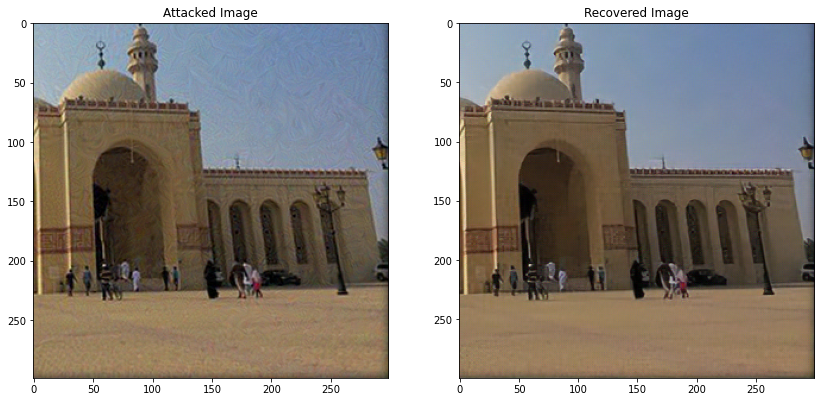

Correct Answer : 669
Prediction - attacked : 874
Prediction - recovered :  669


In [ ]:
attacked = func.to_tensor(attacked)
recovered = result.to('cpu').resize(3, 300, 300)

print_tensor_image(attacked, recovered)

print('Correct Answer :',  df.loc[947]['TrueLabel'])

cls_model.to(device)
cls_model.eval()
with torch.no_grad() :
  pred1 = cls_model(preprocess(attacked.unsqueeze(0).to(device)))
  pred2 = cls_model(preprocess(recovered.unsqueeze(0).to(device)))
pred1 = torch.argmax(pred1).item() + 1
pred2 = torch.argmax(pred2).item() + 1

print('Prediction - attacked :', pred1)
print('Prediction - recovered : ', pred2)